In [31]:
import time
import numpy as np 
import pandas as pd 
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d   ## smoother
from tqdm.notebook import tqdm, tnrange

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from sklearn.preprocessing import MinMaxScaler
        
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold


def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/test_features.csv


In [32]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
    
device

'cuda'

In [33]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test_features = pd.read_csv('../input/lish-moa/test_features.csv')
submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [34]:
top_features = [  1,   2,   3,   4,   5,   6,   7,   9,  11,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  78,  79,  80,  81,  82,  83,  84,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
       198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280,
       281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294,
       295, 296, 298, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
       324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
       337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
       350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 390, 391,
       392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404,
       405, 406, 407, 408, 409, 411, 412, 413, 414, 415, 416, 417, 418,
       419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 434, 435, 436, 437, 438, 439, 440, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 477, 478, 479, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 498, 500, 501, 502, 503, 505,
       506, 507, 509, 510, 511, 512, 513, 514, 515, 518, 519, 520, 521,
       522, 523, 524, 525, 526, 527, 528, 530, 531, 532, 534, 535, 536,
       538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 549, 550, 551,
       552, 554, 557, 559, 560, 561, 562, 565, 566, 567, 568, 569, 570,
       571, 572, 573, 574, 575, 577, 578, 580, 581, 582, 583, 584, 585,
       586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 599,
       600, 601, 602, 606, 607, 608, 609, 611, 612, 613, 615, 616, 617,
       618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630,
       631, 632, 633, 634, 635, 636, 637, 638, 639, 641, 642, 643, 644,
       645, 646, 647, 648, 649, 650, 651, 652, 654, 655, 656, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685,
       686, 687, 688, 689, 691, 692, 693, 694, 695, 696, 697, 699, 700,
       701, 702, 704, 705, 707, 708, 709, 710, 711, 713, 714, 716, 717,
       718, 720, 721, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732,
       733, 734, 735, 737, 738, 739, 740, 742, 743, 744, 745, 746, 747,
       748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 759, 760, 761,
       762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774,
       775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788,
       789, 790, 792, 793, 794, 795, 796, 797, 798, 800, 801, 802, 803,
       804, 805, 806, 808, 809, 811, 813, 814, 815, 816, 817, 818, 819,
       821, 822, 823, 825, 826, 827, 828, 829, 830, 831, 832, 834, 835,
       837, 838, 839, 840, 841, 842, 845, 846, 847, 848, 850, 851, 852,
       854, 855, 856, 858, 859, 860, 861, 862, 864, 866, 867, 868, 869,
       870, 871, 872, 873, 874]

drop_list =[]
for i in range(875):
    if i not in top_features:
        drop_list.append(i)
        
print(len(drop_list), "features to be dropped")

90 features to be dropped


In [35]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [36]:
train_features=train_features.drop(train_features.columns[drop_list], axis=1)

In [37]:
train_features.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-5,g-7,g-10,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-1.0120,-0.0326,1.1830,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,0.5207,0.3372,-1.1520,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,1.2390,0.2155,-0.4797,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,-0.8095,0.1792,-0.8269,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,-0.8244,-0.1498,-0.2219,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [38]:
ignore_columns = ['sig_id', "cp_type"]

train_columns = [x for x in train_features.columns if x not in ignore_columns]

train = train_features[train_columns]
test = test_features[train_columns]
target = train_targets_scored.iloc[:,1:].values

In [39]:
transform = ColumnTransformer([
                            ('o',OneHotEncoder(),[0,1]),
                            ('s',Normalizer(),list(range(3,train.shape[1])))  ## remove
                        ])


train = transform.fit_transform(train)
test = transform.transform(test)

In [40]:
train.shape, test.shape, target.shape

((23814, 787), (3982, 787), (23814, 206))

In [41]:
class TrainDataset(Dataset):
    def __init__(self, train,targets, noise ):
        
        self.features  = train
        self.targets = targets
        self.noise = noise
        
    def sizes(self):
        print("features size = ", self.features.shape[1])
        print("targets size = ", self.targets.shape[1])

        
    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx]).float() 
        
#         if self.noise == True:
# #             print("noisy boi")
#             feature  = feature + torch.randn_like(feature)/150
            
        target = torch.tensor(self.targets[idx]).float()
        
        return feature,target

In [42]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def train_step(x, y, model, optimizer, criterion):
    optimizer.zero_grad()
    pred = model(x.to(device))
    y = y.float()
    loss = criterion(pred,y.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

In [43]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(787)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(787, 1048))
        
        self.batch_norm2 = nn.BatchNorm1d(1048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(1048, 2096))
        
        self.batch_norm3 = nn.BatchNorm1d(2096)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(2096, 2096))
        
        self.batch_norm4 = nn.BatchNorm1d(2096)
        self.dropout4 = nn.Dropout(0.5)
        self.dense4 = nn.utils.weight_norm(nn.Linear(2096, 1048))
        
        self.batch_norm5 = nn.BatchNorm1d(1048)
        #self.dropout5 = nn.Dropout(0.5)
        self.dense5 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.leaky_relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.leaky_relu(self.dense3(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = F.leaky_relu(self.dense4(x))
        
        x = self.batch_norm5(x)
        #x = self.dropout5(x)
        x = (self.dense5(x))
        
        return x
    
    
    
model = Model()

In [44]:
def train_one_fold(model,num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 1, show_plots = False, train = True, validate = True):
    
    losses = []
    val_losses = []
    learning_rates = []    
    best_loss = 1000000

    for epoch in range(num_epochs):

            
        if train == True:
            model.train()
            losses_temp = []
            for batch in train_loader:
                (x_batch, y_batch) = batch
                loss = train_step(x_batch.to(device), y_batch.to(device), model, optimizer, criterion)
                losses_temp.append(loss)
            losses.append(torch.mean(torch.tensor(losses_temp)))
            scheduler.step(1.)   ## lr decay caller 
            learning_rates.append(get_lr(optimizer))
            

        if validate == True:
            with torch.no_grad():
                model.eval()
                val_losses_temp = []
                for x_val, y_val in val_loader:
                    yhat =model(x_val.to(device))  # pred 
                    val_loss = criterion(yhat.to(device), y_val.to(device))
                    val_losses_temp.append(val_loss.item())  ## metrics 
                val_losses.append(torch.mean(torch.tensor(val_losses_temp)).item())  ## metrics 

        
        if train == True:
            print ("epoch ", epoch+1, " out of ", num_epochs, end = "      >" )

            if val_losses[-1] <= best_loss:

                print(CGREEN, "Val loss decreased from:", best_loss, " to ", val_losses[-1], CEND, end = "   >")
                best_loss = val_losses[-1]

                name = "./model_" + str(fold_number)+".pth"

                print("saving model as: ", name)

                torch.save(model.state_dict(), name)

            else: 
                print("showing no improvements, best loss yet:", best_loss)

        if show_plots == True:

            show_lr(learning_rates)
            plt.plot(val_losses, label = "val")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(val_losses[4:], label = "val after main drop", c = "g")
            plt.axhline(min(val_losses), linestyle = "--", c = "r")
            plt.legend()
            plt.grid()
            plt.show()


            plt.plot(losses, label = "train")
            plt.legend()
            plt.grid()
            plt.show()
        
    return losses, val_losses

In [45]:
## building folds 

CGREEN  = '\33[32m'
CBLUE =  '\033[34m'
CRED = '\033[1;31m'
CEND  = '\33[0m'

NFOLDS =10
num_epochs = 40

kfold = KFold(NFOLDS,shuffle=True,random_state=42)
fold_train_losses = list()
fold_valid_losses = list()


for k , (train_idx,valid_idx) in enumerate(kfold.split(train)):

    x_train,x_valid,y_train,y_valid = train[train_idx,:],train[valid_idx,:],target[train_idx,:],target[valid_idx,:]

    input_size = x_train.shape[1]
    output_size = target.shape[1]
    
    
    train_dataset = TrainDataset(x_train, y_train, noise = False)
    valid_dataset = TrainDataset(x_valid, y_valid, noise = False)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers = 8)

    val_loader = DataLoader(dataset=valid_dataset, batch_size=256, shuffle = True, num_workers = 8)
    
    model = Model()
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.4e-3)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min', 
                                                     factor=0.5, 
                                                     patience=5, 
                                                     eps=1e-5, 
                                                     verbose=True)
    criterion = nn.BCEWithLogitsLoss()
    print(CRED ,"fold ", str(k+1), CEND)

    train_one_fold(model, num_epochs , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = k+1)
    
print(CBLUE, "Training complete", CEND)

 fold  1 
epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.06186182051897049    >saving model as:  ./model_1.pth
epoch  2  out of  2      > Val loss decreased from: 0.06186182051897049  to  0.02875644899904728    >saving model as:  ./model_1.pth
 fold  2 
epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.06153801828622818    >saving model as:  ./model_2.pth
epoch  2  out of  2      > Val loss decreased from: 0.06153801828622818  to  0.029762383550405502    >saving model as:  ./model_2.pth
 fold  3 
epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.06069359928369522    >saving model as:  ./model_3.pth
epoch  2  out of  2      > Val loss decreased from: 0.06069359928369522  to  0.028773153200745583    >saving model as:  ./model_3.pth
 fold  4 
epoch  1  out of  2      > Val loss decreased from: 1000000  to  0.06014334037899971    >saving model as:  ./model_4.pth
epoch  2  out of  2      > Val loss decreased from: 0.06014334037899971  to

In [46]:
all_models = [Model() for i in range (NFOLDS)]

for i in range (len(all_models)):
    
    name = "./model_" + str(i + 1) + ".pth"
    all_models[i].load_state_dict(torch.load(name))
    all_models[i].to(device)
    print("Loaded: ", name)

Loaded:  ./model_1.pth
Loaded:  ./model_2.pth
Loaded:  ./model_3.pth
Loaded:  ./model_4.pth
Loaded:  ./model_5.pth
Loaded:  ./model_6.pth
Loaded:  ./model_7.pth
Loaded:  ./model_8.pth
Loaded:  ./model_9.pth
Loaded:  ./model_10.pth


In [47]:
all_val_losses = []
for i in range(NFOLDS):
    losses, val_losses = train_one_fold(all_models[i],5 , train_loader,val_loader, optimizer, scheduler, criterion, fold_number = 0, train = False, validate = True)
    all_val_losses.append(np.mean(np.array(val_losses)))
all_val_losses = np.array(all_val_losses)

In [48]:
class model_jury(object):   ## only works for dataloaders for batch size 1 
    def __init__(self, all_models):
        self.all_models = all_models
        
        
        
    def predict(self, x, plot = False, sigmoid = False):
        
        with torch.no_grad():
            
            if sigmoid == False:
                preds = [self.all_models[i](x.to(device)).view(-1).cpu().tolist() for i in range(len(self.all_models))]
            else:
                preds = [self.all_models[i](x.to(device)).view(-1).cpu().sigmoid().tolist() for i in range(len(self.all_models))]

        
        if plot == True:
            for pred in preds:
                plt.plot(pred)
            plt.show()
            
        preds = np.array(preds)
        mean = np.mean(preds, axis = 0)
        return mean.flatten()
jury = model_jury(all_models)


In [49]:
test_dataset = TrainDataset(test, target, noise = False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers = 8)
val_loader_test_jury = DataLoader(dataset= valid_dataset, batch_size=1, shuffle=False, num_workers = 8)

In [50]:
with torch.no_grad():
    benchmark_losses = []
    criterion = nn.BCEWithLogitsLoss()
    for batch in tqdm(val_loader_test_jury):
        x, y = batch
        pred = jury.predict(x, plot = False, sigmoid = False)
        pred = torch.tensor(pred).view(1,-1)

        benchmark_losses.append(criterion(pred, y))

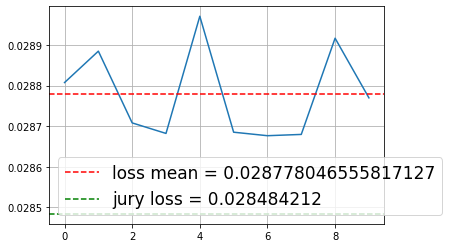

In [51]:
plt.plot(all_val_losses)
plt.axhline(y = all_val_losses.mean(), label = "loss mean = " + str(all_val_losses.mean()), c = "r", linestyle = "--")
plt.axhline(y = np.array(benchmark_losses).mean(), label = "jury loss = " + str(np.array(benchmark_losses).mean()), c = "g", linestyle = "--")
plt.legend(fontsize = 17)
plt.grid()
plt.show()

In [52]:
list_of_preds = []
for batch in tqdm(test_loader):
    x, y = batch
    foo = jury.predict(x, plot = False, sigmoid = True)
    list_of_preds.append(foo)

submission = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub_cp = submission
sub_cp.to_csv('./submission_cp.csv', index=None, header=True)

import csv 
a = list_of_preds  
with open('./submission_cp.csv', "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(a)

final_sub = pd.read_csv('./submission_cp.csv', header = None)

final_sub.columns = submission.columns[1:]
final_sub["sig_id"] = submission["sig_id"]

good_cols = np.roll(final_sub.columns.values, 1)
final_sub = final_sub[good_cols]

In [53]:
final_sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.015194,0.015917,0.015485,0.018907,0.023239,0.016816,0.016174,0.016310,0.015095,...,0.014700,0.015237,0.015754,0.015884,0.016530,0.015190,0.017941,0.015520,0.015286,0.015403
1,id_001897cda,0.015002,0.015721,0.015557,0.018712,0.021169,0.016743,0.015852,0.016036,0.015021,...,0.014707,0.015497,0.015638,0.022640,0.016745,0.015194,0.018651,0.015458,0.015498,0.015068
2,id_002429b5b,0.014672,0.014762,0.015905,0.015030,0.016099,0.014116,0.014874,0.016651,0.015205,...,0.015259,0.014747,0.014536,0.011562,0.014111,0.014804,0.013534,0.015534,0.015041,0.017019
3,id_00276f245,0.015084,0.015793,0.015470,0.018872,0.022525,0.016786,0.016031,0.016189,0.015033,...,0.014672,0.015272,0.015658,0.017571,0.016538,0.015153,0.018136,0.015435,0.015333,0.015271
4,id_0027f1083,0.013877,0.014205,0.015334,0.012764,0.014661,0.012300,0.013814,0.017005,0.015093,...,0.015173,0.013788,0.014368,0.005579,0.012934,0.014348,0.011609,0.015236,0.014245,0.017491


In [54]:
targets = [col for col in final_sub.columns]
final_sub.loc[test_features['cp_type']=='ctl_vehicle', targets[1:]] = 0
final_sub.to_csv('submission.csv', index=False)

In [55]:
final_sub[:30]

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.015194,0.015917,0.015485,0.018907,0.023239,0.016816,0.016174,0.016310,0.015095,...,0.014700,0.015237,0.015754,0.015884,0.016530,0.015190,0.017941,0.015520,0.015286,0.015403
1,id_001897cda,0.015002,0.015721,0.015557,0.018712,0.021169,0.016743,0.015852,0.016036,0.015021,...,0.014707,0.015497,0.015638,0.022640,0.016745,0.015194,0.018651,0.015458,0.015498,0.015068
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.015084,0.015793,0.015470,0.018872,0.022525,0.016786,0.016031,0.016189,0.015033,...,0.014672,0.015272,0.015658,0.017571,0.016538,0.015153,0.018136,0.015435,0.015333,0.015271
4,id_0027f1083,0.013877,0.014205,0.015334,0.012764,0.014661,0.012300,0.013814,0.017005,0.015093,...,0.015173,0.013788,0.014368,0.005579,0.012934,0.014348,0.011609,0.015236,0.014245,0.017491
5,id_0042c1364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,id_006fc47b8,0.015002,0.015152,0.015684,0.018674,0.019522,0.016676,0.015706,0.015916,0.015584,...,0.015209,0.015316,0.015109,0.022034,0.016000,0.015200,0.017166,0.015478,0.015788,0.015937
7,id_0071d65a2,0.015272,0.016028,0.015501,0.018908,0.023884,0.016868,0.016300,0.016448,0.015158,...,0.014722,0.015192,0.015785,0.014462,0.016506,0.015227,0.017782,0.015563,0.015259,0.015478
8,id_007a2159c,0.014890,0.015484,0.015550,0.017871,0.018365,0.016310,0.015484,0.015504,0.014888,...,0.014653,0.015644,0.015595,0.032035,0.016865,0.015099,0.019093,0.015324,0.015447,0.014756
9,id_009201382,0.015225,0.015877,0.015459,0.018976,0.023321,0.016869,0.016055,0.016414,0.015079,...,0.014716,0.015296,0.015857,0.016099,0.016488,0.015210,0.017851,0.015524,0.015278,0.015463
